#CASE ESTRATÉGIA DE CUPONS - IFOOD
Marcella Andrade Ribeiro Seixas

Premissas:
 - o ifood está financiando o custo total do cupom
 - o valor do cupom ainda não esta descontado do valor do pedido, fiz dessa forma pq o valor do desconto na coluna de descontos está igual a 0 em todos os pedidos
 - existem order_id duplicados mas com datas diferentes, considerei que são pedidos diferentes, então criei uma coluna concatenada de order_id + order_created_at
 - Custo com cupom R$ 10,00 por unidade
 - O cupom é aplicado apenas na primeira compra
 - Margem de contribuição 25%


## 1. Importação de bibliotecas e leitura dos dados

In [35]:
# IMPORTAÇÕES USADAS EM TODO O NOTEBOOK
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import min as spark_min, max as spark_max, col, sum, avg, countDistinct, lit, from_json, explode, datediff, current_date, expr, mean, percentile_approx, count, isnan, when
from pyspark.sql.functions import col, countDistinct, count, isnan, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField, ArrayType, BooleanType, LongType, FloatType
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import ClusteringEvaluator # Importar para avaliação

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tarfile
import gzip
import shutil
import builtins

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA

In [36]:
# INICIAR SESSÃO SPARK
# Aumentando a memória do driver.
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 8g pyspark-shell"

# Criar a SparkSession
spark = SparkSession.builder.appName("EDA iFood AB Test").getOrCreate()

# CRIAR DIRETÓRIO E BAIXAR OS ARQUIVOS

# Links dos arquivos
urls = {
    "order.json.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz",
    "consumer.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz",
    "restaurant.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz",
    "ab_test_ref.tar.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"
}

# Criar diretório
os.makedirs("data", exist_ok=True)

# Baixar arquivos
for filename, url in urls.items():
    # Usar -nc para não sobrescrever arquivos existentes se já baixados
    os.system(f"wget -nc -O data/{filename} {url}")

# DESCOMPACTAR

# Extrair o .tar.gz
with tarfile.open("data/ab_test_ref.tar.gz", "r:gz") as tar:
    tar.extractall(path="data")

# Descompactar os .gz (JSON e CSV)
for fname in ["order.json.gz", "consumer.csv.gz", "restaurant.csv.gz"]:
    with gzip.open(f"data/{fname}", "rb") as f_in:
        with open(f"data/{fname[:-3]}", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

 ## 2. Extração, Transformação e Carga (ETL)

 Nesta etapa realizo:
 - Leitura dos dados brutos de pedidos, clientes, restaurantes e teste A/B.
 - Conversão do campo `items` de string para array de JSON.
 - Explosão dos itens para cálculo correto do valor do pedido.
 - Junções entre as tabelas e criação de colunas auxiliares.

In [37]:
# LEITURA DOS DATA
df_orders = spark.read.json("data/order.json")
df_consumers = spark.read.option("header", True).csv("data/consumer.csv")
df_restaurants = spark.read.option("header", True).csv("data/restaurant.csv")
df_ab = spark.read.option("header", True).csv("data/ab_test_ref.csv")


In [38]:
# Mostrar schema de cada DataFrame
print(" Schema dos Dados")
df_orders.printSchema()
df_consumers.printSchema()
df_restaurants.printSchema()
df_ab.printSchema()

# Contar registros em cada dataset
print("\n Quantidade de Registros")
print(f"Pedidos: {df_orders.count()}")
print(f"Consumidores: {df_consumers.count()}")
print(f"Restaurantes: {df_restaurants.count()}")
print(f"Teste A/B: {df_ab.count()}")

# Mostrar amostras de dados
print("\n Amostras")
df_orders.show(5, truncate=False)
df_consumers.show(5, truncate=False)
df_restaurants.show(5, truncate=False)
df_ab.show(5, truncate=False)

# Verificar valores nulos (com tipo tratado)
def missing_data(df, name):
    print(f"\n Valores Nulos em {name}")
    null_exprs = []
    for c in df.schema.fields:
        col_name = c.name
        col_type = c.dataType
        if isinstance(col_type, (FloatType, DoubleType)):
            expr = count(when(col(col_name).isNull() | isnan(col(col_name)), col_name)).alias(col_name)
        else:
            expr = count(when(col(col_name).isNull(), col_name)).alias(col_name)
        null_exprs.append(expr)
    df.select(null_exprs).show()

missing_data(df_orders, "Pedidos")
missing_data(df_consumers, "Consumidores")
missing_data(df_restaurants, "Restaurantes")
missing_data(df_ab, "A/B Test")

# Contar valores distintos por coluna
def distinct_counts(df, name):
    print(f"\n Contagem de Valores Distintos em {name}")
    for c in df.columns:
        df.select(countDistinct(col(c)).alias(f"{c}_distinct")).show(1)

distinct_counts(df_orders, "Pedidos")
distinct_counts(df_consumers, "Consumidores")
distinct_counts(df_restaurants, "Restaurantes")
distinct_counts(df_ab, "A/B Test")

# Estatísticas descritivas
print("\n Estatísticas Descritivas dos Pedidos")
df_orders.describe().show()

print("\n Estatísticas Descritivas dos Consumidores")
df_consumers.describe().show()

print("\n Estatísticas Descritivas dos Restaurantes")
df_restaurants.describe().show()


 Schema dos Dados
root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nul

In [39]:
# Na tabela de pedidos
# Agrupar por order_id e contar quantas linhas distintas existem por ID
df_orders.groupBy("order_id") \
    .agg(count("*").alias("qtde_linhas"),
         countDistinct(*df_orders.columns).alias("qtde_linhas_distintas")) \
    .filter(col("qtde_linhas") > 1) \
    .withColumn("duplicados_diferentes", col("qtde_linhas") != col("qtde_linhas_distintas")) \
    .show(truncate=False)

+----------------------------------------------------------------+-----------+---------------------+---------------------+
|order_id                                                        |qtde_linhas|qtde_linhas_distintas|duplicados_diferentes|
+----------------------------------------------------------------+-----------+---------------------+---------------------+
|ae5b32ded2db12dfdc92aa7c115f0d60609ee02e5c544179f3f50c7c8f93b71e|2          |0                    |true                 |
|d6a33e4a155fcebd48f10bafc20a47368458ee0e39ecb45da815702d8077641b|2          |0                    |true                 |
|58c4a56c8059ea97a80d6f856163ec34048062d893f36c06a03ff1b5bf1aa2e7|2          |0                    |true                 |
|f0aa3ae5d3daa87d20f037f7426ed4805db9b01b72eb08b9d9401d2edee363be|2          |0                    |true                 |
|bc7ed9b93fdf6853ba4867da2b3c78993a68a1a09c32b16708488e2f26396006|2          |0                    |true                 |
|1c7454b351f8d64

In [40]:
# # Agora vou verificar qual informação não está duplicada para fazer uma chave e subescrever o order_id

# # Identificar order_id duplicados (com mais de uma ocorrência)
# duplicated_ids_all = df_orders.groupBy("order_id") \
#     .agg(count("*").alias("qtde")) \
#     .filter("qtde > 1") \
#     .select("order_id")

# df_duplicados_all = df_orders.join(duplicated_ids_all, on="order_id", how="inner")

# # Amostrar 1% dos registros duplicados
# df_duplicados_sample = df_duplicados_all.sample(fraction=0.01, seed=42)

# # Identificar colunas com valores diferentes entre registros com mesmo order_id
# colunas_diferentes = []

# for coluna in df_duplicados_sample.columns:
#     if coluna != "order_id":
#         diferentes = df_duplicados_sample.groupBy("order_id") \
#             .agg(countDistinct(col(coluna)).alias("diff")) \
#             .filter("diff > 1") \
#             .limit(1) \
#             .count()
#         if diferentes > 0:
#             colunas_diferentes.append(coluna)

# print(" Colunas com valores diferentes entre registros com mesmo order_id (1% dos duplicados):")
# for c in colunas_diferentes:
#     print(f"- {c}")


In [41]:
# Vou deixar o código acima comentado pois demora bastante para rodar mesmo olhando apenas para 1% da base
# Vou criar uma chave de id_pedido e order_created_at uma vez que o mesmo id_pedido se repete mas com datas diferentes

df_orders = df_orders.withColumn(
    "order_id", concat_ws("_", col("order_id"), col("order_created_at"))
)

In [42]:
# Nessa etapa vou ajustar os tipos das colunas

df_orders_final = df_orders.withColumn("delivery_address_latitude", col("delivery_address_latitude").cast(DoubleType())) \
    .withColumn("delivery_address_longitude", col("delivery_address_longitude").cast(DoubleType())) \
    .withColumn("merchant_latitude", col("merchant_latitude").cast(DoubleType())) \
    .withColumn("merchant_longitude", col("merchant_longitude").cast(DoubleType())) \
    .withColumn("order_created_at", to_timestamp("order_created_at")) \
    .withColumn("order_scheduled_date", to_timestamp("order_scheduled_date")) \
    .withColumn("order_scheduled", col("order_scheduled").cast(BooleanType()))

df_consumers = df_consumers.withColumn("created_at", to_timestamp("created_at")) \
    .withColumn("active", col("active").cast(BooleanType()))

df_restaurants = df_restaurants.withColumn("created_at", to_timestamp("created_at")) \
    .withColumn("enabled", col("enabled").cast(BooleanType())) \
    .withColumn("price_range", col("price_range").cast(IntegerType())) \
    .withColumn("average_ticket", col("average_ticket").cast(DoubleType())) \
    .withColumn("delivery_time", col("delivery_time").cast(IntegerType())) \
    .withColumn("minimum_order_value", col("minimum_order_value").cast(DoubleType()))

# Na tabela de pedidos vi que existem customer_id nulos, como os pedidos precisam estar relacionados a um customer_id, vou excluir essas linhas
df_orders_final = df_orders_final.filter(col("customer_id").isNotNull())


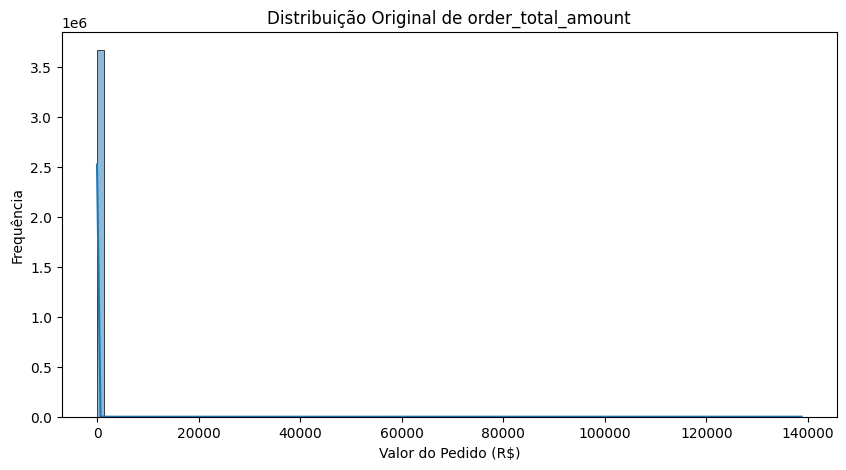

In [43]:
# Vi que  os valores da coluna order_total_amount variam entre 0 e 138750,9, então vou plotar o grafico da distribuição dos valores dos pedidos para entender se temos outliers

order_values_pdf = df_orders.select("order_total_amount") \
    .dropna() \
    .toPandas()

plt.figure(figsize=(10, 5))
sns.histplot(order_values_pdf["order_total_amount"], bins=100, kde=True)
plt.title("Distribuição Original de order_total_amount")
plt.xlabel("Valor do Pedido (R$)")
plt.ylabel("Frequência")
plt.show()


Total de pedidos (antes): 3670826
Total de pedidos (após remoção de outliers): 3459939
Outliers removidos: 210887
Intervalo considerado normal: de R$ -18.85 até R$ 103.15


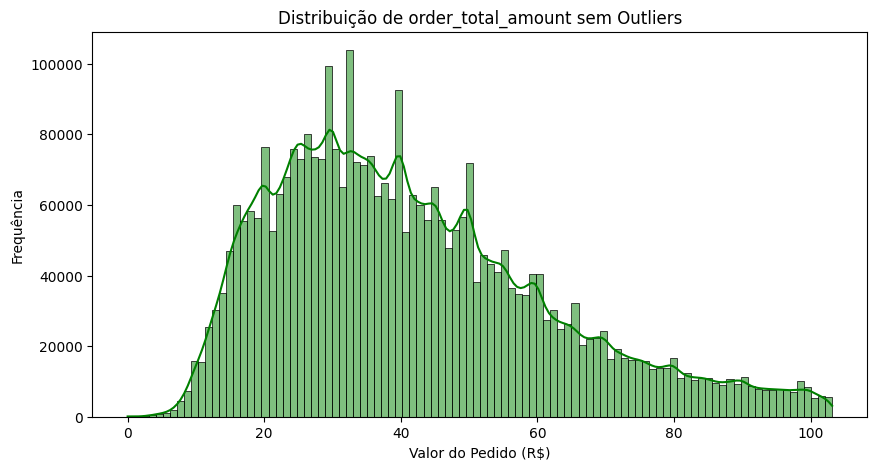

In [44]:
# Como temos uma distribuição que não é normal, vou criar uma função para exclusão dos outliers

# Função para remover outliers via IQR
def remover_outliers_iqr(df, coluna):
    q1 = df[coluna].quantile(0.25)
    q3 = df[coluna].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    df_sem_outliers = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]
    return df_sem_outliers, limite_inferior, limite_superior

df_orders_final, lim_inf, lim_sup = remover_outliers_iqr(order_values_pdf, "order_total_amount")

total_original = len(order_values_pdf)
total_sem_outliers = len(df_orders_final)
outliers_removidos = total_original - total_sem_outliers

print(f"\nTotal de pedidos (antes): {total_original}")
print(f"Total de pedidos (após remoção de outliers): {total_sem_outliers}")
print(f"Outliers removidos: {outliers_removidos}")
print(f"Intervalo considerado normal: de R$ {lim_inf:.2f} até R$ {lim_sup:.2f}")

plt.figure(figsize=(10, 5))
sns.histplot(df_orders_final["order_total_amount"], bins=100, kde=True, color="green")
plt.title("Distribuição de order_total_amount sem Outliers")
plt.xlabel("Valor do Pedido (R$)")
plt.ylabel("Frequência")
plt.show()

In [45]:
# Agora que ja vi como vai ficar, vou seguir com a aplicação da remoção de outliers na tabela

lim_inf = order_values_pdf["order_total_amount"].quantile(0.25) - 1.5 * (order_values_pdf["order_total_amount"].quantile(0.75) - order_values_pdf["order_total_amount"].quantile(0.25))
lim_sup = order_values_pdf["order_total_amount"].quantile(0.75) + 1.5 * (order_values_pdf["order_total_amount"].quantile(0.75) - order_values_pdf["order_total_amount"].quantile(0.25))

df_orders_final = df_orders.filter(
    (col("order_total_amount") >= lim_inf) & (col("order_total_amount") <= lim_sup)
)

df_orders_final.count()

3459939

In [46]:
# Vi que dentro da coluna "items" temos um array, vou visualizar uma linha apenas para entender o que tem dentro
df_orders_final.select("items").show(1, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
df_orders_final.filter(col("order_total_amount") == 0).select("items").show(1, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [48]:
# Como vi que existem campos que formam o "order_total_amount" vou explodir o array

price_schema = StructType([
    StructField("value", StringType(), True),
    StructField("currency", StringType(), True)
])

garnish_schema = StructType([
    StructField("name", StringType(), True),
    StructField("addition", price_schema, True),
    StructField("discount", price_schema, True),
    StructField("quantity", DoubleType(), True),
    StructField("sequence", DoubleType(), True),
    StructField("unitPrice", price_schema, True),
    StructField("categoryId", StringType(), True),
    StructField("externalId", StringType(), True),
    StructField("totalValue", price_schema, True),
    StructField("categoryName", StringType(), True),
    StructField("integrationId", StringType(), True)
])

item_schema = StructType([
    StructField("name", StringType(), True),
    StructField("addition", price_schema, True),
    StructField("discount", price_schema, True),
    StructField("quantity", DoubleType(), True),
    StructField("sequence", DoubleType(), True),
    StructField("unitPrice", price_schema, True),
    StructField("externalId", StringType(), True),
    StructField("totalValue", price_schema, True),
    StructField("customerNote", StringType(), True),
    StructField("garnishItems", ArrayType(garnish_schema), True),
    StructField("integrationId", StringType(), True),
    StructField("totalAddition", price_schema, True),
    StructField("totalDiscount", price_schema, True)
])

items_array_schema = ArrayType(item_schema)

df_orders_final = df_orders_final.withColumn("items_struct", from_json("items", items_array_schema))

df_parsed = df_orders_final.withColumn("items_array", from_json("items", ArrayType(item_schema)))
df_items_exploded = df_parsed.select(
    "order_id",
    explode("items_array").alias("item")
).select(
    "order_id",
    col("item.name").alias("item_name"),
    col("item.quantity").alias("item_quantity"),
    col("item.unitPrice.value").cast("double").alias("item_unit_price"),
    col("item.totalValue.value").cast("double").alias("item_total_value"),
    col("item.totalAddition.value").cast("double").alias("item_total_addition"),
    col("item.totalDiscount.value").cast("double").alias("item_total_discount")
)

df_items_exploded.show(5)


+--------------------+--------------------+-------------+---------------+----------------+-------------------+-------------------+
|            order_id|           item_name|item_quantity|item_unit_price|item_total_value|item_total_addition|item_total_discount|
+--------------------+--------------------+-------------+---------------+----------------+-------------------+-------------------+
|33e0612d62e5eb42a...|Parmegiana de Fil...|          1.0|         2800.0|          2800.0|                0.0|                0.0|
|33e0612d62e5eb42a...|Lasanha Frango (2...|          1.0|         1800.0|          1800.0|                0.0|                0.0|
|c37e495a91b498bb7...|    GRANDE 2 SABORES|          1.0|            0.0|             0.0|                0.0|                0.0|
|b4df94142d2135461...|           CALABRESA|          1.0|         2040.0|          2040.0|                0.0|                0.0|
|b4df94142d2135461...|       CHEESE SALADA|          1.0|         2040.0|          

In [49]:
# Me parece que a coluna de descontos está zerada, vou confirmar para entender se preciso criar uma coluna de valor liquido

valores = df_items_exploded.select(
    min("item_total_discount").alias("min_discount"),
    max("item_total_discount").alias("max_discount")
).collect()[0]

min_desc = float(valores["min_discount"])
max_desc = float(valores["max_discount"])

if min_desc == 0 and max_desc == 0:
    texto = 'Não existe valor de desconto, usar o campo "order_total_amount" da tabela de pedidos.'
else:
    texto = "Realizar o calculo a partir dos valores do array"

print(texto)


Não existe valor de desconto, usar o campo "order_total_amount" da tabela de pedidos.


In [50]:
# Como não tem desconto aplicado, vou verificar se tem valor de pedido total = 0 e se tiver vou excluir

# Verificar se existem pedidos com valor total igual a zero
df_orders_final.filter(F.col("order_total_amount") == 0).count()
df_orders_final.count()
df_orders_final = df_orders_final.filter(F.col("order_total_amount") > 0)
df_orders_final.count()

3459785

In [51]:
# Fazer o join da tabela de pedidos com a marcação do grupo

df_orders_ab = df_orders_final.join(df_ab, on="customer_id", how="inner")
df_orders_ab.show(5)

+--------------------+-----------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+--------------------+---------+
|         customer_id|        cpf|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|        items_struct|is_target|
+---------

In [52]:
#Criando a base que será utilizada posteriormente para fazer algumas analises como media x mediana por customer_id

from pyspark.sql.functions import (
    col, count, countDistinct, avg, sum as spark_sum,
    min, max, datediff, round as spark_round, first
)
window_user = Window.partitionBy("customer_id").orderBy("order_created_at")

df_aux = df_orders_ab.withColumn("primeiro_pedido", min("order_created_at").over(window_user)) \
                     .withColumn("ultimo_pedido", max("order_created_at").over(window_user)) \
                     .withColumn("dias_desde_ultimo_pedido", datediff(F.current_date(), col("ultimo_pedido"))) \
                     .withColumn("tempo_vida", datediff(col("ultimo_pedido"), col("primeiro_pedido"))) \
                     .withColumn("estado_cliente", first("delivery_address_state").over(window_user)) \
                     .withColumn("plataforma_cliente", first("origin_platform").over(window_user))

df_final = df_aux.groupBy("customer_id", "is_target").agg(
    count("order_id").alias("qtd_pedidos"),
    spark_sum("order_total_amount").alias("valor_total_gasto"),
    avg("order_total_amount").alias("ticket_medio"),
    spark_round(count("order_id") / (datediff(max("order_created_at"), min("order_created_at")) / 30 + 1), 2).alias("frequencia_mensal"),
    max("dias_desde_ultimo_pedido").alias("dias_desde_ultimo_pedido"),
    countDistinct("merchant_id").alias("qtd_restaurantes_diferentes"),
    max("tempo_vida").alias("tempo_vida"),
    first("estado_cliente").alias("estado"),
    first("plataforma_cliente").alias("plataforma")
)

df_final.show(10)
df_final.count()
df_final.describe().show()

+--------------------+---------+-----------+-----------------+------------------+-----------------+------------------------+---------------------------+----------+------+----------+
|         customer_id|is_target|qtd_pedidos|valor_total_gasto|      ticket_medio|frequencia_mensal|dias_desde_ultimo_pedido|qtd_restaurantes_diferentes|tempo_vida|estado|plataforma|
+--------------------+---------+-----------+-----------------+------------------+-----------------+------------------------+---------------------------+----------+------+----------+
|00021cd56b6d6c980...|   target|          5|             79.7|15.940000000000001|              2.0|                    2408|                          3|        45|    SP|   ANDROID|
|00029b26fb2121119...|   target|          1|             54.6|              54.6|              1.0|                    2366|                          1|         0|    RJ|       IOS|
|0002cc7394d677fdf...|  control|          2|             87.8|              43.9|         

In [53]:
#Comparando média x mediana das colunas numéricas

numericas = [
    "qtd_pedidos", "valor_total_gasto", "ticket_medio",
    "frequencia_mensal", "dias_desde_ultimo_pedido",
    "qtd_restaurantes_diferentes", "tempo_vida"
]

aggs = []
for col_name in numericas:
    aggs.append(mean(col_name).alias(f"{col_name}_media"))
    aggs.append(percentile_approx(col_name, 0.5, 100).alias(f"{col_name}_mediana"))

df_estatisticas_ab = df_final.groupBy("is_target").agg(*aggs)

df_estatisticas_ab.show(truncate=False)

+---------+-----------------+-------------------+-----------------------+-------------------------+------------------+--------------------+-----------------------+-------------------------+------------------------------+--------------------------------+---------------------------------+-----------------------------------+------------------+------------------+
|is_target|qtd_pedidos_media|qtd_pedidos_mediana|valor_total_gasto_media|valor_total_gasto_mediana|ticket_medio_media|ticket_medio_mediana|frequencia_mensal_media|frequencia_mensal_mediana|dias_desde_ultimo_pedido_media|dias_desde_ultimo_pedido_mediana|qtd_restaurantes_diferentes_media|qtd_restaurantes_diferentes_mediana|tempo_vida_media  |tempo_vida_mediana|
+---------+-----------------+-------------------+-----------------------+-------------------------+------------------+--------------------+-----------------------+-------------------------+------------------------------+--------------------------------+-----------------------

## 3. Inicio das *Análises* do teste A/B

- Cálculo da Retenção (target x control)
- Cálculo da Frequência (target x control)
- Cálculo do ticket médio (target x control)
- Cálculo da Recência (target x control)

In [54]:
# CALCULO DA RETENÇÃO:  Mede se os usuários voltaram a comprar após a primeira compra (ou após a campanha).

df_pedidos_por_usuario = df_orders_ab.groupBy("customer_id", "is_target") \
    .agg(F.count("order_id").alias("qtd_pedidos"))

df_pedidos_por_usuario = df_pedidos_por_usuario.withColumn("retido", F.col("qtd_pedidos") > 1)

df_retencao = df_pedidos_por_usuario.groupBy("is_target") \
    .agg(
        F.sum(F.col("retido").cast("int")).alias("usuarios_retidos"),
        F.count("customer_id").alias("total_usuarios")
    ) \
    .withColumn("taxa_retencao", F.col("usuarios_retidos") / F.col("total_usuarios"))

df_retencao.show()

retencao = df_retencao.collect()

taxa_target = None
taxa_controle = None

for linha in retencao:
    is_target = str(linha["is_target"]).lower()  # transforma em string padronizada
    if is_target in ["target"]:  # considera True ou 1 como target
        taxa_target = float(linha["taxa_retencao"])
    elif is_target in ["control"]:
        taxa_controle = float(linha["taxa_retencao"])

if taxa_target is not None and taxa_controle is not None and taxa_target > taxa_controle:
    variacao = ((taxa_target - taxa_controle) / taxa_controle) * 100
    texto = (
        f"A taxa de retenção do grupo **target** foi de {taxa_target:.2%}, "
        f"enquanto a do grupo **controle** foi de {taxa_controle:.2%}. "
        f"Ou seja, a campanha de cupons aumentou a retenção em {variacao:.2f}%."
    )
else:
    texto = ""

print(texto)


+---------+----------------+--------------+------------------+
|is_target|usuarios_retidos|total_usuarios|     taxa_retencao|
+---------+----------------+--------------+------------------+
|  control|          259645|        348621| 0.744777279624578|
|   target|          342537|        433013|0.7910547720276296|
+---------+----------------+--------------+------------------+

A taxa de retenção do grupo **target** foi de 79.11%, enquanto a do grupo **controle** foi de 74.48%. Ou seja, a campanha de cupons aumentou a retenção em 6.21%.


In [55]:
#Para confirmar se a diferença na retenção é estatisticamente significativa, vou rodar um teste de hipótese (Z-test para proporções).

resultado = df_retencao.collect()

for linha in resultado:
    if linha['is_target'] == 'control':
        retidos_control = linha['usuarios_retidos']
        total_control = linha['total_usuarios']
    elif linha['is_target'] == 'target':
        retidos_target = linha['usuarios_retidos']
        total_target = linha['total_usuarios']

successes = [retidos_control, retidos_target]
totals = [total_control, total_target]

z_stat, p_value = proportions_ztest(count=successes, nobs=totals)

print(f"Z-Stat: {z_stat:.3f}")
print(f"p-valor: {p_value:.6f}")

if p_value < 0.05:
    interpretacao = (
        f"Como o p-valor foi de {p_value:.6f}, menor que 0.05, "
        f"concluímos que a diferença de retenção entre os grupos é estatisticamente significativa. "
        f"Ou seja, a campanha de cupons **teve impacto real na retenção de usuários**."
    )
else:
    interpretacao = (
        f"O p-valor foi de {p_value:.6f}, maior ou igual a 0.05. "
        f"Isto indica que a diferença observada pode ter ocorrido por acaso, "
        f"e não há evidência estatística suficiente para afirmar que a campanha de cupons teve efeito real."
    )

print(interpretacao)

Z-Stat: -48.357
p-valor: 0.000000
Como o p-valor foi de 0.000000, menor que 0.05, concluímos que a diferença de retenção entre os grupos é estatisticamente significativa. Ou seja, a campanha de cupons **teve impacto real na retenção de usuários**.


In [56]:
# CÁLCULO DA FREQUÊNCIA: Quantidade de pedidos por usuário em determinado período.

df_pedidos_por_usuario = df_orders_ab.groupBy("customer_id", "is_target") \
    .agg(F.count("order_id").alias("qtd_pedidos"))

df_pedidos_por_usuario.groupBy("is_target").agg(
    F.expr("percentile_approx(qtd_pedidos, 0.5)").alias("mediana_pedidos")
).show()

df_freq_pd = df_pedidos_por_usuario.toPandas()

freq_control = df_freq_pd[df_freq_pd["is_target"] == "control"]["qtd_pedidos"]
freq_target = df_freq_pd[df_freq_pd["is_target"] == "target"]["qtd_pedidos"]

# Calcular as medianas - Vou usar a mediana pois vi anteriormente que temos outliers e quero evitar viés de outliers
mediana_target = freq_target.median()
mediana_control = freq_control.median()
diferenca_mediana = mediana_target - mediana_control

u_stat, p_val_mw = mannwhitneyu(freq_target, freq_control, alternative='two-sided')

if p_val_mw < 0.05:
    interpretacao = (
        f"A mediana de pedidos por usuário foi de {mediana_target:.2f} no grupo **target**, "
        f"contra {mediana_control:.2f} no grupo **controle**, resultando em uma diferença de {diferenca_mediana:.2f} pedidos por usuário.\n\n"
        f"O p-valor do teste de Mann-Whitney foi de {p_val_mw:.6f}, indicando que essa diferença **é estatisticamente significativa**.\n\n"
        f"Portanto, a campanha de cupons **aumentou a mediana de pedidos por usuário**."
    )
else:
    interpretacao = (
        f"A mediana de pedidos por usuário foi de {mediana_target:.2f} no grupo **target**, "
        f"contra {mediana_control:.2f} no grupo **controle**, com uma diferença de {diferenca_mediana:.2f} pedidos por usuário.\n\n"
        f"Contudo, o p-valor do teste de Mann-Whitney foi de {p_val_mw:.6f}, indicando que **a diferença não é estatisticamente significativa**.\n\n"
        f"Portanto, **não é possível afirmar que a campanha de cupons aumentou o número típico de pedidos por usuário**."
    )

print("\nInterpretação com base na MEDIANA:\n\n")
print(interpretacao)


+---------+---------------+
|is_target|mediana_pedidos|
+---------+---------------+
|  control|              2|
|   target|              3|
+---------+---------------+


Interpretação com base na MEDIANA:


A mediana de pedidos por usuário foi de 3.00 no grupo **target**, contra 2.00 no grupo **controle**, resultando em uma diferença de 1.00 pedidos por usuário.

O p-valor do teste de Mann-Whitney foi de 0.000000, indicando que essa diferença **é estatisticamente significativa**.

Portanto, a campanha de cupons **aumentou a mediana de pedidos por usuário**.


In [57]:
# TICKET MÉDIO

# Calcular ticket médio por pedido por usuário - vou usar a média por ser um indicador financeiro, uma vez que representa bem o gasto médio por pedido
df_ticket_usuario = df_orders_ab.groupBy("customer_id") \
    .agg(F.avg("order_total_amount").alias("ticket_medio_usuario"))

df_ticket_usuario = df_ticket_usuario.join(
    df_orders_ab.select("customer_id", "is_target").dropDuplicates(),
    on="customer_id"
)
df_ticket_usuario_group = df_ticket_usuario.groupBy("is_target") \
    .agg(F.avg("ticket_medio_usuario").alias("ticket_medio_grupo"))

df_ticket_usuario_group.show()

df_ticket_pd = df_ticket_usuario.toPandas()

ticket_control = df_ticket_pd[df_ticket_pd["is_target"] == "control"]["ticket_medio_usuario"]
ticket_target = df_ticket_pd[df_ticket_pd["is_target"] == "target"]["ticket_medio_usuario"]

t_stat, p_value = ttest_ind(ticket_target, ticket_control, equal_var=False)

media_ticket_target = ticket_target.mean()
media_ticket_control = ticket_control.mean()
dif_ticket = media_ticket_target - media_ticket_control

if p_value < 0.05:
    interpretacao_ticket = (
        f"O ticket médio por usuário foi de R$ {media_ticket_target:.2f} no grupo **target**, "
        f"contra R$ {media_ticket_control:.2f} no grupo **controle**, representando uma diferença de R$ {dif_ticket:.2f}.\n\n"
        f"Como o p-valor foi de {p_value:.6f}, essa diferença é estatisticamente significativa.\n\n"
        f"Portanto, a campanha de cupons **também contribuiu para elevar o valor médio gasto por pedido por usuário**."
    )
else:
    interpretacao_ticket = (
        f"O ticket médio por usuário foi de R$ {media_ticket_target:.2f} no grupo **target**, "
        f"contra R$ {media_ticket_control:.2f} no grupo **controle**, com uma diferença de R$ {dif_ticket:.2f}.\n\n"
        f"No entanto, como o p-valor foi de {p_value:.6f}, **essa diferença não é estatisticamente significativa**.\n\n"
        f"Dessa forma, **não é possível concluir que a campanha tenha impactado o ticket médio por usuário**."
    )

print("\nInterpretação - Ticket Médio:\n\n")
print(interpretacao_ticket)

+---------+------------------+
|is_target|ticket_medio_grupo|
+---------+------------------+
|  control|42.253097461727286|
|   target| 42.31879514763588|
+---------+------------------+


Interpretação - Ticket Médio:


O ticket médio por usuário foi de R$ 42.32 no grupo **target**, contra R$ 42.25 no grupo **controle**, com uma diferença de R$ 0.07.

No entanto, como o p-valor foi de 0.111705, **essa diferença não é estatisticamente significativa**.

Dessa forma, **não é possível concluir que a campanha tenha impactado o ticket médio por usuário**.


In [58]:
#CALCULO DA RECêNCIA

window_user = Window.partitionBy("customer_id").orderBy("order_created_at")

df_diff = df_orders_ab.withColumn("pedido_anterior", F.lag("order_created_at").over(window_user)) \
                      .withColumn("dias_entre_pedidos", F.datediff("order_created_at", "pedido_anterior"))

# Calcular recência por usuário (como mediana aproximada) - Vou usar a mediana pois usuários muito inativos (ex: 300 dias entre pedidos) distorcem a média.
df_recencia_usuario = df_diff.groupBy("customer_id") \
    .agg(F.expr("percentile_approx(dias_entre_pedidos, 0.5)").alias("recencia_mediana"))

df_recencia_usuario = df_recencia_usuario.join(
    df_orders_ab.select("customer_id", "is_target").dropDuplicates(),
    on="customer_id"
)

df_recencia_grupo = df_recencia_usuario.groupBy("is_target") \
    .agg(F.expr("percentile_approx(recencia_mediana, 0.5)").alias("recencia_mediana_grupo"))

df_recencia_grupo.show()

df_recencia_pd = df_recencia_usuario.toPandas()

recencia_control = df_recencia_pd[df_recencia_pd["is_target"] == "control"]["recencia_mediana"].dropna()
recencia_target = df_recencia_pd[df_recencia_pd["is_target"] == "target"]["recencia_mediana"].dropna()

u_stat, p_value = mannwhitneyu(recencia_target, recencia_control, alternative='two-sided')

mediana_rec_control = recencia_control.median()
mediana_rec_target = recencia_target.median()
dif_recencia = mediana_rec_control - mediana_rec_target  # positiva = target compra mais rápido

if p_value < 0.05:
    interpretacao_recencia = (
        f"A mediana do tempo entre pedidos (recência) foi de {mediana_rec_target:.1f} dias no grupo **target** "
        f"e {mediana_rec_control:.1f} dias no grupo **controle**, uma diferença de {dif_recencia:.1f} dias.\n\n"
        f"Como o p-valor foi de {p_value:.6f}, essa diferença é estatisticamente significativa.\n\n"
        f"Isso indica que os usuários que receberam o cupom **compraram com menor intervalo entre os pedidos**, "
        f"sugerindo aumento na frequência de compra no grupo tratado."
    )
else:
    interpretacao_recencia = (
        f"A mediana do tempo entre pedidos (recência) foi de {mediana_rec_target:.1f} dias no grupo **target** "
        f"e {mediana_rec_control:.1f} dias no grupo **controle**, uma diferença de {dif_recencia:.1f} dias.\n\n"
        f"No entanto, como o p-valor foi de {p_value:.6f}, essa diferença **não é estatisticamente significativa**.\n\n"
        f"Portanto, não é possível afirmar que a campanha de cupons tenha alterado a frequência de compras."
    )

print("\nInterpretação - Recência (Mediana):\n\n")
print(interpretacao_recencia)


+---------+----------------------+
|is_target|recencia_mediana_grupo|
+---------+----------------------+
|  control|                     9|
|   target|                     7|
+---------+----------------------+


Interpretação - Recência (Mediana):


A mediana do tempo entre pedidos (recência) foi de 7.0 dias no grupo **target** e 9.0 dias no grupo **controle**, uma diferença de 2.0 dias.

Como o p-valor foi de 0.000000, essa diferença é estatisticamente significativa.

Isso indica que os usuários que receberam o cupom **compraram com menor intervalo entre os pedidos**, sugerindo aumento na frequência de compra no grupo tratado.


##4. Análise de Viabilidade Financeira

Nessa etapa, vou considerar que ainda precisamos tirar do "order_total_amount" o valor do cupom.

Como premissa:

- Vou colocar o custo do cupom como R$10,00 e vou assumir que o iFood financiou 100% do valor do cupom;
- A intenção da campanha não é lucro mas sim reter usuários e aumentar o LTV no médio prazo;
- A margem de contribuição da empresa é de 25%


In [59]:
# ANALISE DE VIABILIDADE FINANCEIRA CONSIDERANDO QUE AINDA PRECISAMOS TIRAR DO order_total_amount O VALOR DO CUPOM

# Dados extraídos das análises anteriores

# Taxas de retenção
retencao_target = retidos_target / total_target
retencao_control = retidos_control / total_control

# Número de usuários
usuarios_target = total_target
usuarios_control = total_control

# Frequência média de pedidos - aqui vou usar a meédia pois quero ver o impacto financeiro total, ROI
frequencia_target = freq_target.mean()
frequencia_control = freq_control.mean()

# Ticket médio por pedido (assumindo ticket por pedido, não por usuário)
ticket_medio = (ticket_control.mean() + ticket_target.mean()) / 2  # média entre os dois

# Margem de contribuição da empresa
margem = 0.25  # 25%

# Custo por usuário impactado com push/email/suporte
custo_unitario = 10.00
custo_total = custo_unitario * usuarios_target

# ----------------------------
# Receita Incremental

# Pedidos adicionais
pedidos_control_esperados = usuarios_target * frequencia_control
pedidos_target_reais = usuarios_target * frequencia_target
pedidos_adicionais = pedidos_target_reais - pedidos_control_esperados

# Receita incremental bruta
receita_incremental = pedidos_adicionais * ticket_medio

# ----------------------------
# Lucro Líquido

lucro_liquido = (retencao_target - retencao_control) * usuarios_target * ticket_medio * margem - custo_total

# ----------------------------
# ROI

roi = lucro_liquido / custo_total if custo_total != 0 else 0

# ----------------------------
# Texto automático

print("📊 Análise de Viabilidade Financeira:")

print(f"\nA campanha gerou uma **receita incremental estimada** de R$ {receita_incremental:,.2f}, "
      f"resultado dos pedidos adicionais feitos pelos usuários do grupo target em relação ao grupo controle.")

print(f"\nConsiderando a margem de contribuição da empresa (25%) e o custo total da campanha "
      f"(R$ {custo_total:,.2f}), o **lucro líquido estimado** foi de R$ {lucro_liquido:,.2f}.")

print(f"\nO **Retorno sobre o Investimento (ROI)** da campanha foi de {roi:.2%}.")

# Interpretação final
if roi > 0:
    print(f"\nIsso indica que a campanha foi financeiramente viável, com retorno positivo sobre o investimento.")
else:
    print(f"\nIsso indica que a campanha **não foi financeiramente viável**, pois o retorno foi negativo.")


📊 Análise de Viabilidade Financeira:

A campanha gerou uma **receita incremental estimada** de R$ 9,595,780.02, resultado dos pedidos adicionais feitos pelos usuários do grupo target em relação ao grupo controle.

Considerando a margem de contribuição da empresa (25%) e o custo total da campanha (R$ 4,330,130.00), o **lucro líquido estimado** foi de R$ -4,118,290.56.

O **Retorno sobre o Investimento (ROI)** da campanha foi de -95.11%.

Isso indica que a campanha **não foi financeiramente viável**, pois o retorno foi negativo.


In [60]:
# Como o objetivo do teste não era o lucro mas sim reter mais usuários e aumentar a receita futura média por cliente (LTV), mesmo que à custa de um prejuízo inicial, vou realizar os demais calculos para entender se o objetivo foi cumprido:

# LTV estimado por grupo
ltv_control = retencao_control * frequencia_control * ticket_control.mean() * margem
ltv_target = retencao_target * frequencia_target * ticket_target.mean() * margem

incremento_ltv = ltv_target - ltv_control

# Receita futura incremental por usuário
receita_futura_incr_por_usuario = incremento_ltv

# Payback = custo por usuário / receita incremental por usuário
payback_meses = custo_unitario / receita_futura_incr_por_usuario if receita_futura_incr_por_usuario > 0 else float('inf')

print("\n📈 Análise de LTV e Retenção:")

print(f"\n- LTV estimado por usuário no grupo controle: R$ {ltv_control:.2f}")
print(f"- LTV estimado por usuário no grupo target:   R$ {ltv_target:.2f}")
print(f"- Incremento de LTV por usuário:              R$ {incremento_ltv:.2f}")

if incremento_ltv > 0:
    print(f"\nIsso indica que, apesar do prejuízo imediato, a campanha **aumentou o valor futuro esperado por usuário**.")

    if payback_meses != float('inf'):
        print(f"O investimento da campanha pode ser recuperado em aproximadamente {payback_meses:.1f} meses via LTV incremental.")
    else:
        print("No entanto, a receita incremental por usuário não é suficiente para recuperar o investimento.")

else:
    print("\nA campanha não aumentou o LTV médio por usuário em relação ao grupo controle.")


📈 Análise de LTV e Retenção:

- LTV estimado por usuário no grupo controle: R$ 32.47
- LTV estimado por usuário no grupo target:   R$ 38.93
- Incremento de LTV por usuário:              R$ 6.46

Isso indica que, apesar do prejuízo imediato, a campanha **aumentou o valor futuro esperado por usuário**.
O investimento da campanha pode ser recuperado em aproximadamente 1.5 meses via LTV incremental.


## 5. Segmentação

In [61]:
from sklearn.preprocessing import StandardScaler
# 1. Converter o DataFrame Spark para Pandas
df_kmeans_pd = df_final.select(
    "customer_id",  # importante manter para depois
    "qtd_pedidos", "ticket_medio", "frequencia_mensal",
    "dias_desde_ultimo_pedido", "valor_total_gasto",
    "qtd_restaurantes_diferentes", "tempo_vida"
).toPandas()

df_kmeans_pd.dropna(inplace=True)

colunas_numericas = [
    "qtd_pedidos", "ticket_medio", "frequencia_mensal",
    "dias_desde_ultimo_pedido", "valor_total_gasto",
    "qtd_restaurantes_diferentes", "tempo_vida"
]

# Remover outliers extremos (p01 e p99) de forma robusta
for col in colunas_numericas:
    p01 = df_kmeans_pd[col].quantile(0.01)
    p99 = df_kmeans_pd[col].quantile(0.99)
    df_kmeans_pd = df_kmeans_pd.loc[df_kmeans_pd[col].between(p01, p99)]

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_pd[colunas_numericas])


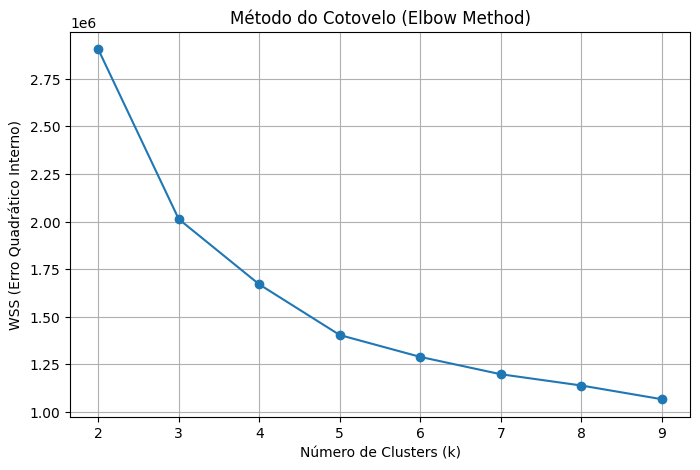

In [62]:
# Vou rodar o ELbow Method para definir o número ideal de k
wss = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wss.append(kmeans.inertia_)  # inertia_ = WSS

plt.figure(figsize=(8, 5))
plt.plot(ks, wss, marker='o')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WSS (Erro Quadrático Interno)')
plt.grid(True)
plt.show()

Calculando o índice de Calinski-Harabasz para cada valor de K:

K = 2: Índice de Calinski-Harabasz = 541199.35
K = 3: Índice de Calinski-Harabasz = 551219.41
K = 4: Índice de Calinski-Harabasz = 492572.24
K = 5: Índice de Calinski-Harabasz = 473801.48
K = 6: Índice de Calinski-Harabasz = 425757.07
K = 7: Índice de Calinski-Harabasz = 390942.00
K = 8: Índice de Calinski-Harabasz = 357886.47
K = 9: Índice de Calinski-Harabasz = 340435.72


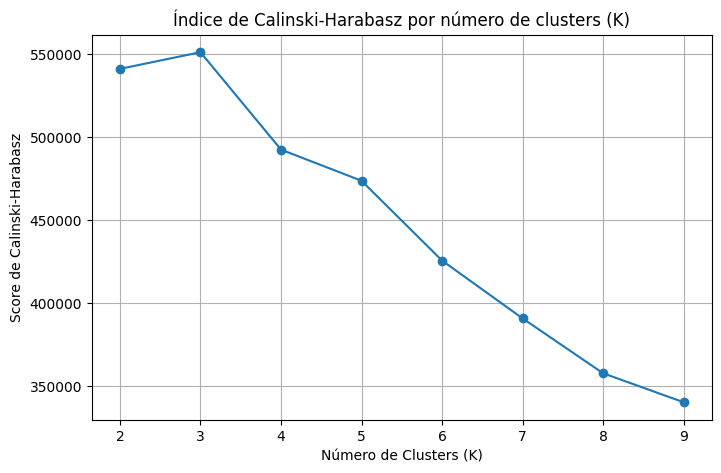

In [63]:
# Como achei que pelo ELbow Method ficou um pouco inconclusivo, vou o calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# Calcular índice de Calinski-Harabasz para diferentes valores de K
ch_scores = []
K_range = range(2, 10)

print("Calculando o índice de Calinski-Harabasz para cada valor de K:\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, cluster_labels)
    ch_scores.append(score)

    print(f"K = {k}: Índice de Calinski-Harabasz = {score:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(K_range, ch_scores, marker='o')
plt.title("Índice de Calinski-Harabasz por número de clusters (K)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Score de Calinski-Harabasz")
plt.grid(True)
plt.show()


Resumo dos clusters:

         qtd_pedidos  ticket_medio  frequencia_mensal  \
cluster                                                 
0               9.57         43.39               3.76   
1               3.11         41.58               1.44   
2               1.32         42.71               1.21   

         dias_desde_ultimo_pedido  valor_total_gasto  \
cluster                                                
0                         2407.56             399.55   
1                         2401.83             127.20   
2                         2373.22              55.46   

         qtd_restaurantes_diferentes  tempo_vida  
cluster                                           
0                               4.01       46.14  
1                               1.52       33.98  
2                               1.21        1.89  


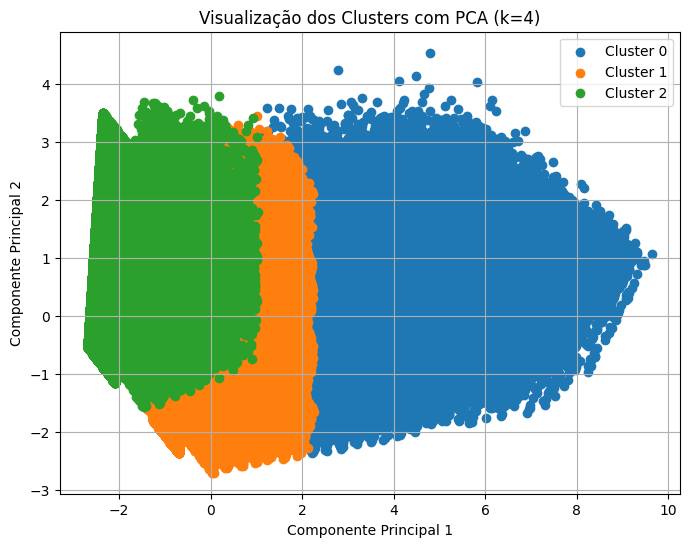

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar o KMeans com k=3 devido ao resultado que encontrei no calinski_harabasz_score, onde deve-se usar o k com o maior score
k =3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

df_kmeans_pd['cluster'] = cluster_labels

cluster_summary = df_kmeans_pd.groupby('cluster').agg({
    'qtd_pedidos': 'mean',
    'ticket_medio': 'mean',
    'frequencia_mensal': 'mean',
    'dias_desde_ultimo_pedido': 'mean',
    'valor_total_gasto': 'mean',
    'qtd_restaurantes_diferentes': 'mean',
    'tempo_vida': 'mean'
}).round(2)

print("Resumo dos clusters:\n")
print(cluster_summary)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(
        X_pca[cluster_labels == i, 0],
        X_pca[cluster_labels == i, 1],
        label=f'Cluster {i}'
    )

plt.title("Visualização dos Clusters com PCA (k=4)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# Mapear clusters para nomes fixos com base em valor_total_gasto médio
cluster_map = (
    df_kmeans_pd.groupby('cluster')['valor_total_gasto']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

rename_dict = {row['cluster']: idx for idx, row in cluster_map.iterrows()}

df_kmeans_pd['cluster_ordenado'] = df_kmeans_pd['cluster'].map(rename_dict)


In [66]:
# Dicionário de rótulos para os clusters
nomes_clusters = {
    0: "Usuários Frequentes e Engajados",
    1: "Usuários Ocasionalmente Ativos",
    2: "Usuários Novos ou Inativos"
}

df_kmeans_pd['cluster_nome'] = df_kmeans_pd['cluster_ordenado'].map(nomes_clusters)


In [67]:
df_ab_pd = df_ab.select("customer_id", "is_target").dropDuplicates().toPandas()

# JUNÇÃO dos dados de cluster com os grupos A/B
df_analise = df_kmeans_pd.merge(df_ab_pd, on='customer_id', how='inner')

# AGRUPAMENTO e MÉTRICAS por cluster e grupo A/B
agrupamento = df_analise.groupby(['cluster_nome', 'is_target']).agg({
    'qtd_pedidos': 'mean',
    'ticket_medio': 'mean',
    'valor_total_gasto': 'mean',
    'frequencia_mensal': 'mean',
    'dias_desde_ultimo_pedido': 'mean',
    'qtd_restaurantes_diferentes': 'mean',
    'tempo_vida': 'mean',
    'customer_id': 'count'  # nº de usuários no grupo
}).rename(columns={'customer_id': 'num_usuarios'}).reset_index()

# Visualizar o resultado
print(agrupamento.to_string(index=False))


                   cluster_nome is_target  qtd_pedidos  ticket_medio  valor_total_gasto  frequencia_mensal  dias_desde_ultimo_pedido  qtd_restaurantes_diferentes  tempo_vida  num_usuarios
Usuários Frequentes e Engajados   control     9.559545     43.475356         399.837544           3.756150               2407.532738                     3.997522   46.115881         49240
Usuários Frequentes e Engajados    target     9.571845     43.329199         399.363362           3.758729               2407.577815                     4.015006   46.152083         73039
     Usuários Novos ou Inativos   control     1.268410     42.686272          53.485492           1.177214               2373.096802                     1.180216    1.601775        103748
     Usuários Novos ou Inativos    target     1.358608     42.737898          57.229508           1.236908               2373.330736                     1.239271    2.141681        115781
 Usuários Ocasionalmente Ativos   control     2.996806     4

## Conclusão

- Manter campanhas para usuários novos/inativos e ocasionalmente ativos, pois há impacto claro.

- Evitar oferecer cupons para usuários muito engajados nessa campanha, pois não traz ROI adicional — eles comprariam mesmo sem incentivo.




ROI por cluster:
                      cluster_nome  receita_incremental_total  custo_campanha  \
0  Usuários Frequentes e Engajados              -3.463377e+04       1095585.0   
1       Usuários Novos ou Inativos               4.334858e+05       1736715.0   
2   Usuários Ocasionalmente Ativos               1.761340e+06       3181605.0   

        roi  
0 -1.031612  
1 -0.750399  
2 -0.446399  


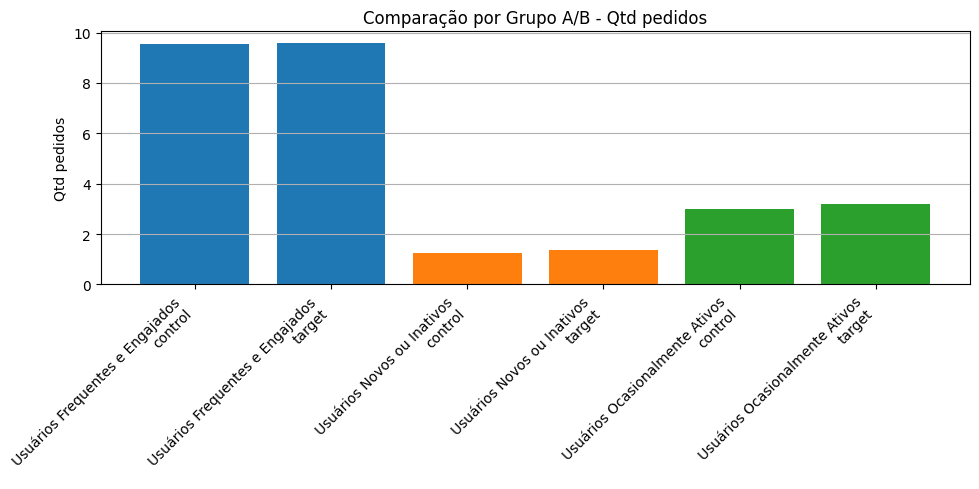

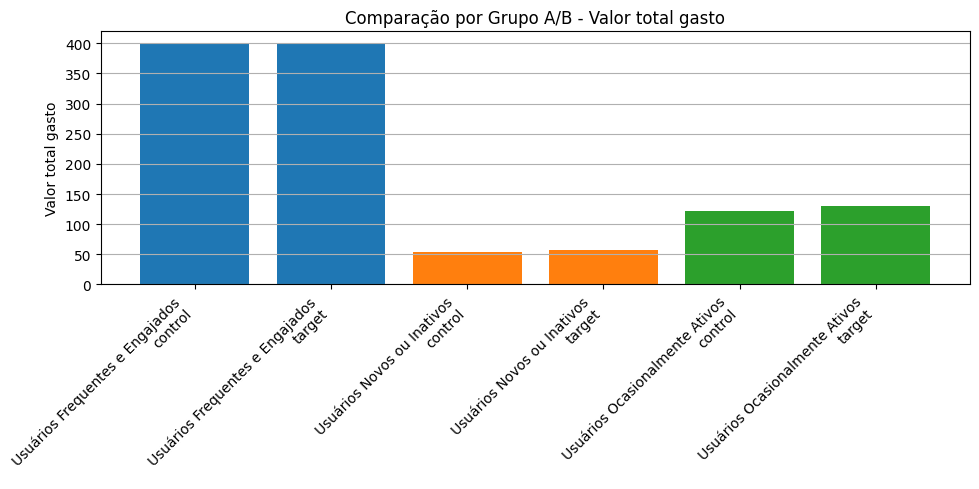

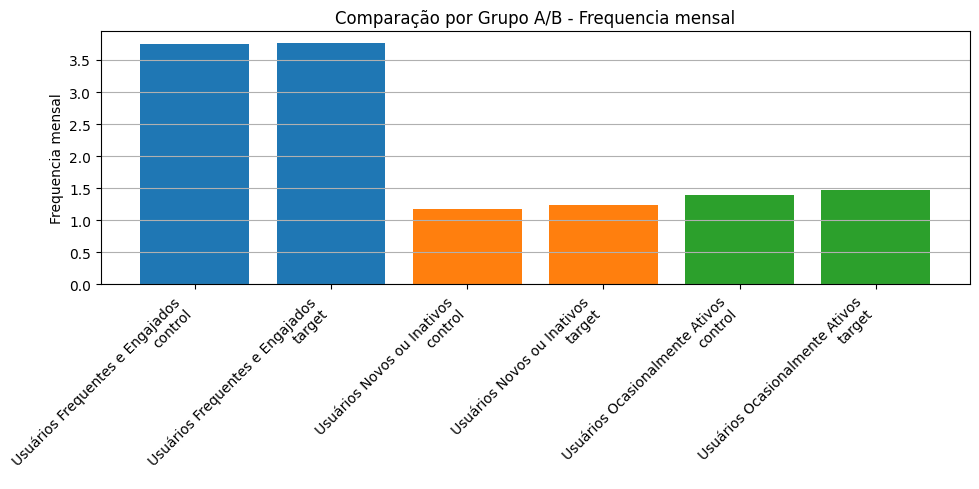

In [72]:
# Reorganizar os dados em formato wide para cálculo de ROI
df_roi = agrupamento.pivot(index='cluster_nome', columns='is_target', values=[
    'valor_total_gasto', 'num_usuarios'
])
df_roi.columns = ['_'.join(col).strip() for col in df_roi.columns.values]
df_roi = df_roi.reset_index()

# Calcular Receita Incremental e ROI
df_roi['receita_incremental_total'] = (
    (df_roi['valor_total_gasto_target'] - df_roi['valor_total_gasto_control']) *
    df_roi['num_usuarios_target']
)
df_roi['custo_campanha'] = df_roi['num_usuarios_target'] * 15
df_roi['roi'] = (df_roi['receita_incremental_total'] - df_roi['custo_campanha']) / df_roi['custo_campanha']
df_roi.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nROI por cluster:")
print(df_roi[['cluster_nome', 'receita_incremental_total', 'custo_campanha', 'roi']])

# Gráficos comparativos por cluster e grupo
metrics = ['qtd_pedidos', 'valor_total_gasto', 'frequencia_mensal']
for metric in metrics:
    plt.figure(figsize=(10, 5))
    for cluster in agrupamento['cluster_nome'].unique():
        dados = agrupamento[agrupamento['cluster_nome'] == cluster]
        plt.bar(
            [f'{cluster}\n{grupo}' for grupo in dados['is_target']],
            dados[metric],
            label=cluster
        )
    plt.title(f'Comparação por Grupo A/B - {metric.replace("_", " ").capitalize()}')
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()


In [73]:
# Calcular Receita Incremental, ROI e LTV
df_roi = agrupamento.pivot(index='cluster_nome', columns='is_target', values=['valor_total_gasto', 'num_usuarios'])
df_roi.columns = ['_'.join(col).strip() for col in df_roi.columns.values]
df_roi = df_roi.reset_index()

# Custo da campanha (R$10 por usuário target)
df_roi['receita_incremental_total'] = (df_roi['valor_total_gasto_target'] - df_roi['valor_total_gasto_control']) * df_roi['num_usuarios_target']
df_roi['custo_campanha'] = df_roi['num_usuarios_target'] * 10
df_roi['roi'] = (df_roi['receita_incremental_total'] - df_roi['custo_campanha']) / df_roi['custo_campanha']

# LTV médio por grupo
df_roi['ltv_control'] = df_roi['valor_total_gasto_control']
df_roi['ltv_target'] = df_roi['valor_total_gasto_target']
df_roi['incremento_ltv'] = df_roi['ltv_target'] - df_roi['ltv_control']

df_roi.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nMétricas por Cluster (ROI e LTV):\n")
print(df_roi.to_string(index=False))



Métricas por Cluster (ROI e LTV):

                   cluster_nome  valor_total_gasto_control  valor_total_gasto_target  num_usuarios_control  num_usuarios_target  receita_incremental_total  custo_campanha       roi  ltv_control  ltv_target  incremento_ltv
Usuários Frequentes e Engajados                 399.837544                399.363362               49240.0              73039.0              -3.463377e+04        730390.0 -1.047418   399.837544  399.363362       -0.474182
     Usuários Novos ou Inativos                  53.485492                 57.229508              103748.0             115781.0               4.334858e+05       1157810.0 -0.625598    53.485492   57.229508        3.744015
 Usuários Ocasionalmente Ativos                 122.603343                130.907360              170940.0             212107.0               1.761340e+06       2121070.0 -0.169598   122.603343  130.907360        8.304017
